In [105]:
# Utility Libraries
import numpy as np
import pandas as pd
import sys
import time
import random
from scipy import linalg
import cv2
from PIL import Image, ImageDraw
from PIL.Image import fromarray
import os
import torch
import re
import string
import random
import numpy as np
from torch.utils.data import Dataset

# Pytorch relevant libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import cat
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from torchvision.models import inception_v3
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence

# Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.manifold import TSNE

In [3]:
english_data = pd.read_csv('/kaggle/input/en-fr-translation-dataset/en-fr.csv', usecols=[0])

In [28]:
english_data.drop(0, axis=0, inplace=True)

In [52]:
english_data.dropna(inplace=True)

In [ ]:
text = sample[0]
text = re.sub(r'[^' + re.escape(char_list) + ']+', '', text)

In [128]:
noisy_text = []
original_text = []

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz "
num_samples = 1200000
for idx, sample in enumerate(english_data.values[:num_samples]):
    text = sample[0]
    text = re.sub(r'[^' + re.escape(char_list) + ']+', '', text)
    
    for i in range(5):
        
        for i in range(np.random.choice(np.arange(0, 2), p=[0.1, 0.9])):
            txt = list(text)
            try:
                txt[random.randint(0, len(text) - 1)] = random.choice(string.ascii_letters)
                txt = ''.join(txt)
                noisy_text.append(txt)
                original_text.append(text)
            except:
                continue
                
    if idx % 50000 == 0:
        print(f'Done {idx}')

Done 0
Done 50000
Done 100000
Done 150000
Done 200000
Done 250000
Done 300000
Done 350000
Done 400000
Done 450000
Done 500000
Done 550000
Done 600000
Done 650000
Done 700000
Done 750000
Done 800000
Done 850000
Done 900000
Done 950000
Done 1000000
Done 1050000
Done 1100000
Done 1150000


In [266]:
5396279 / 9

599586.5555555555

In [129]:
len(noisy_text)

5396279

In [130]:
len(original_text)

5396279

In [197]:
class NoisyTextDataset(Dataset):
    def __init__(self, noisy_texts, original_texts):
        self.noisy_texts = noisy_texts
        self.original_texts = original_texts
        
        # Create vocabularies for input and output texts
        self.input_vocab = self.build_vocab(noisy_texts)
        self.output_vocab = self.build_vocab(original_texts)
        
        # Create dictionaries for encoding and decoding
        self.input_encoder = {char: idx for idx, char in enumerate(self.input_vocab)}
        self.output_encoder = {char: idx for idx, char in enumerate(self.output_vocab)}
        self.output_decoder = {idx: char for char, idx in self.output_encoder.items()}
        
        # Add start and end tokens to the output vocabulary
        self.output_vocab = ['<sos>'] + self.output_vocab + ['<eos>']
        self.output_encoder = {char: idx for idx, char in enumerate(self.output_vocab)}
        self.output_decoder = {idx: char for char, idx in self.output_encoder.items()}
    
    def build_vocab(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text)
        return sorted(list(vocab))
    
    def __len__(self):
        return len(self.noisy_texts)
    
    def __getitem__(self, idx):
        noisy_text = self.noisy_texts[idx]
        original_text = self.original_texts[idx]

        # Encode input text
        input_tensor = torch.tensor([self.input_encoder[char] for char in noisy_text], dtype=torch.long)

        # Encode output text with start and end tokens
        output_tensor = torch.tensor([self.output_encoder['<sos>']] +
                                     [self.output_encoder[char] for char in original_text] +
                                     [self.output_encoder['<eos>']], dtype=torch.long)

        return input_tensor, output_tensor

    @staticmethod
    def collate_fn(batch):
        noisy_texts, original_texts = zip(*batch)
        
        # Pad the input sequences
        noisy_texts = pad_sequence([seq for seq in noisy_texts], batch_first=True)
        
        # Pad the output sequences
        original_texts = pad_sequence([seq for seq in original_texts], batch_first=True)
        
        return noisy_texts, original_texts

In [297]:
dataset = NoisyTextDataset(noisy_text[:100000], original_text[:100000])

In [298]:
dataloader = DataLoader(dataset, batch_size=64, collate_fn=dataset.collate_fn, shuffle=True)

In [299]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(self.input_dim, self.hidden_dim, num_layers=self.num_layers)
              
    def forward(self, x):
        outputs, hidden = self.gru(x)
        return outputs, hidden

In [300]:
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(Decoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, self.hidden_dim, num_layers=self.num_layers)
        self.out = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x, hidden):
        x = x.view(1, -1)
        output, hidden = self.gru(x, hidden)   
        prediction = self.out(output[0])

        return prediction, hidden

In [301]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

    def forward(self, input_tensor):
        embedded = self.embedding(input_tensor)
        output, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers, dropout):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        # Create the output encoder and decoder
        self.output_vocab = ['<sos>'] + list(range(output_size)) + ['<eos>']
        self.output_encoder = {char: idx for idx, char in enumerate(self.output_vocab)}
        self.output_decoder = {idx: char for char, idx in self.output_encoder.items()}

    def forward(self, input_tensor, hidden, cell):
        embedded = self.embedding(input_tensor)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        output = self.fc(output[:, -1, :])
        return output, hidden, cell

# Define the Seq2Seq Model
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, input_tensor, target_tensor):
        batch_size = input_tensor.size(0)
        max_length = target_tensor.size(1)

        hidden, cell = self.encoder(input_tensor)
        output_tensor = torch.tensor([[self.decoder.output_encoder['<sos>']] for _ in range(batch_size)], device=self.device)

        outputs = []
        for _ in range(max_length):
            output, hidden, cell = self.decoder(output_tensor, hidden, cell)
            outputs.append(output)
            output_tensor = output.argmax(dim=1).unsqueeze(1)

        output_tensor = torch.stack(outputs, dim=1)
        return output_tensor

In [302]:
input_size = len(dataset.input_vocab)
output_size = len(dataset.output_vocab)
hidden_size = 128
num_layers = 2
dropout = 0.2

encoder = Encoder(input_size, hidden_size, num_layers, dropout).to(device)
decoder = Decoder(output_size, hidden_size, num_layers, dropout).to(device)
model = Seq2SeqModel(encoder, decoder, device).to(device)

In [303]:
import time

In [308]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    start_time = time.time()
    loss_trajectory = []  # Store loss values for visualization
    for epoch in range(num_epochs):
        total_loss = 0.0
        num_batches = 0
        for noisy_texts, original_texts in train_loader:  # Changed from dataloader to train_loader
            noisy_texts = noisy_texts.to(device)
            original_texts = original_texts.to(device)

            # Forward pass
            output_tensor = model(noisy_texts, original_texts[:, :-1])
            loss = criterion(output_tensor.view(-1, output_tensor.size(-1)), original_texts[:, 1:].reshape(-1))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            torch.cuda.empty_cache()
            
            num_batches += 1
            if num_batches % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch : {num_batches}, Loss : {loss.item()}, Time Elapsed: {int(time.time() - start_time)} s")

        epoch_loss = total_loss / len(train_loader)
        loss_trajectory.append(epoch_loss)  # Append epoch loss to loss trajectory
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    return model, loss_trajectory

In [309]:
model = Seq2SeqModel(encoder, decoder, device).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.output_encoder['<eos>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

trained_model, loss_trajectory = train_model(model, dataloader, criterion, optimizer, num_epochs, device)

Epoch [1/5], Batch : 100, Loss : 0.42439737915992737, Time Elapsed: 63 s
Epoch [1/5], Batch : 200, Loss : 1.0092434883117676, Time Elapsed: 143 s
Epoch [1/5], Batch : 300, Loss : 1.0295952558517456, Time Elapsed: 208 s
Epoch [1/5], Batch : 400, Loss : 0.7132648229598999, Time Elapsed: 283 s
Epoch [1/5], Batch : 500, Loss : 0.8579282760620117, Time Elapsed: 349 s
Epoch [1/5], Batch : 600, Loss : 1.3687264919281006, Time Elapsed: 425 s
Epoch [1/5], Batch : 700, Loss : 0.6963507533073425, Time Elapsed: 498 s
Epoch [1/5], Batch : 800, Loss : 0.8243837356567383, Time Elapsed: 555 s
Epoch [1/5], Batch : 900, Loss : 0.9210711121559143, Time Elapsed: 621 s
Epoch [1/5], Batch : 1000, Loss : 1.0648376941680908, Time Elapsed: 688 s
Epoch [1/5], Batch : 1100, Loss : 0.9908424615859985, Time Elapsed: 758 s
Epoch [1/5], Batch : 1200, Loss : 0.5746747851371765, Time Elapsed: 828 s
Epoch [1/5], Batch : 1300, Loss : 0.5057827830314636, Time Elapsed: 895 s
Epoch [1/5], Batch : 1400, Loss : 0.51646858453

In [312]:
torch.save(model, 'spelling_corrector.pth')

In [313]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'spelling_corrector.pth')

/kaggle/working


/kaggle/working/spelling_corrector.pth

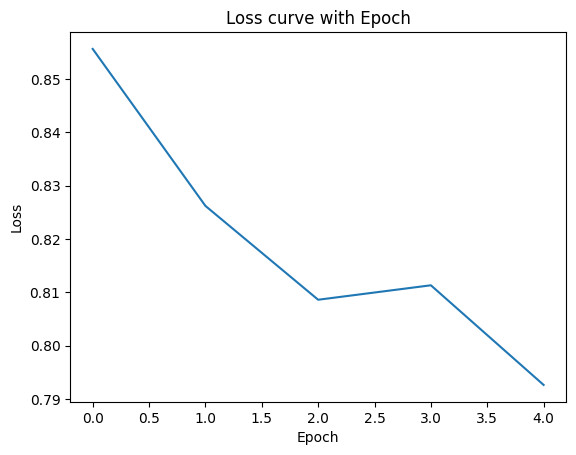

In [315]:
plt.plot(loss_trajectory)
plt.title('Loss curve with Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()